# Setup environment

In [ ]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os
import string
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import pandas as pd
import string
import re
import emoji
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Config

## Model training config

Increasing the size of the text window, such that it encompasses more than all the sentences of the dataset, can have both advantages and disadvantages in a convolutional neural network (CNN):

Advantages:

1. **Global Context**: A larger text window allows the model to capture a broader context of the input text, including long-range dependencies and relationships between distant words or phrases. This can be beneficial for tasks that require understanding of the overall context, such as document classification or sentiment analysis.

2. **Feature Abstraction**: With a larger text window, the CNN can learn more abstract features that span multiple sentences or paragraphs. This can lead to the extraction of higher-level semantic information from the text, enabling the model to make more informed predictions.

3. **Robustness to Noise**: A larger receptive field can help the model to better handle noisy or ambiguous input, as it has access to more contextual information to disambiguate the meaning of words or phrases.

Disadvantages:

1. **Increased Computational Complexity**: Using a larger text window requires processing a greater amount of input data, which can significantly increase the computational complexity and memory requirements of the model. This can lead to longer training times and may make the model less suitable for deployment on resource-constrained devices.

2. **Loss of Local Detail**: A larger text window may result in the loss of fine-grained local information, as the model focuses more on capturing global context. This could potentially degrade performance on tasks that rely heavily on local features or word-level semantics, such as named entity recognition or part-of-speech tagging.

3. **Overfitting**: With a larger receptive field, the model may have a higher risk of overfitting, especially if the dataset is relatively small or if there is insufficient regularization. The model may memorize irrelevant patterns or noise in the input text, leading to poorer generalization performance on unseen data.

Overall, the decision to increase the size of the text window in a CNN should be based on the specific requirements of the task and the characteristics of the dataset. While a larger text window can provide access to richer contextual information, it also comes with trade-offs in terms of computational complexity and potential loss of local detail. Therefore, it's essential to carefully balance these factors to achieve the best performance for the given task.

In [ ]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.001
BATCH_SIZE = 128
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation

## Load Data

In [ ]:
import pandas as pd
twitter_data = pd.read_csv('twitter-suicidal-data.csv')
print(twitter_data.head())

                                             latweet  intention
0  my life is meaningless i just want to end my l...          1
1  muttering i wanna die to myself daily for a fe...          1
2  work slave i really feel like my only purpose ...          1
3  i did something on the 2 of october i overdose...          1
4  i feel like no one cares i just want to die ma...          1


## Data Preprocessing

In [ ]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Converting text to lowercase format is a common preprocessing step in natural language processing (NLP) tasks. Here are the advantages and disadvantages of this process:

Advantages:
1. **Normalization**: Lowercasing helps in normalizing the text by reducing the number of unique tokens. For example, "Hello" and "hello" would be treated as the same word after lowercasing.
2. **Consistency**: Lowercasing ensures that the same word written in different cases is treated as identical, leading to more consistent processing and analysis.
3. **Efficiency**: Lowercasing reduces the complexity of text processing tasks by simplifying the vocabulary. It can speed up processing, especially in tasks like tokenization and feature extraction.

Disadvantages:
1. **Loss of Information**: Lowercasing can lead to the loss of information, especially in cases where the distinction between uppercase and lowercase letters is meaningful. For example, proper nouns or acronyms may lose their distinction.
2. **Contextual Ambiguity**: In some cases, lowercasing can introduce ambiguity or alter the meaning of text. For instance, "US" (United States) and "us" (pronoun) would be treated as the same word after lowercasing.

We typically perform lowercasing towards the end of the preprocessing pipeline to ensure that other text processing steps (such as tokenization, stemming, and stop words removal) are applied consistently to the text. Lowercasing helps in standardizing the text representation before further analysis, making it easier to compare and process.

Removing numbers from text data during preprocessing is a common practice in natural language processing tasks. Here are the advantages and disadvantages of this process:

Advantages:

1. **Improved Text Clarity**: Removing numbers can improve the readability and clarity of text data, especially in tasks like sentiment analysis or topic modeling, where numbers may not contribute to the semantic meaning of the text.
2. **Reduced Vocabulary Size**: Eliminating numbers reduces the size of the vocabulary, which can lead to more efficient processing and better model performance, especially in tasks where numerical values are not relevant.
3. **Focus on Textual Patterns**: By removing numerical values, the focus of analysis shifts towards textual patterns and linguistic features, which may be more relevant for certain NLP tasks such as text classification or information retrieval.

Disadvantages:

1. **Loss of Information**: Removing numbers may lead to the loss of valuable information, especially in domains where numerical data is important for understanding the context. For example, in fields like finance, healthcare, or scientific research, numbers often convey crucial information.
2. **Altered Meaning**: In some cases, numbers may be integral to the meaning of the text. Removing numbers indiscriminately can alter the semantics of the text and potentially lead to misinterpretation or loss of context.
3. **Contextual Importance**: Numbers may carry contextual significance in certain contexts. For instance, dates, times, measurements, or product identifiers are examples where numerical values convey specific meaning. Removing them can degrade the richness of the text representation.

In summary, while removing numbers from text data can enhance text processing and analysis in certain contexts, it's essential to carefully consider the nature of the data and the requirements of the NLP task to determine whether this preprocessing step is beneficial or not.

In natural language processing tasks involving text data from social media platforms like Twitter, hashtags play a significant role in conveying context, topics, trends, and sentiments. Here's why we typically do not remove hashtags during preprocessing and how keeping them can affect the performance of the model:

1. **Contextual Information**: Hashtags provide valuable contextual information about the content of a tweet. They indicate the main topic or theme being discussed, and removing them would result in the loss of this crucial information. By keeping hashtags, the model can better understand the context and make more informed predictions or analyses.

2. **Topic Identification**: Hashtags are commonly used to categorize tweets and group them based on common topics or themes. By preserving hashtags, the model can leverage this information to better identify and categorize tweets, leading to more accurate classification or clustering results.

3. **Sentiment Analysis**: Hashtags often reflect the sentiment or mood associated with a tweet. For example, hashtags like #happy, #excited, or #angry provide insights into the emotional tone of the text. By retaining hashtags, sentiment analysis models can incorporate this information to improve their predictions of sentiment polarity.

4. **Trend Detection**: Hashtags are instrumental in identifying trending topics or events on social media platforms. They help in monitoring real-time discussions and identifying emerging trends. Keeping hashtags allows the model to detect and analyze trending topics, which is valuable for tasks like trend prediction or event detection.

5. **Model Generalization**: Removing hashtags may result in a loss of generalization ability, especially if the model is trained on a diverse range of topics and domains. By retaining hashtags, the model can learn to recognize and adapt to different contexts, leading to better generalization performance across various datasets.

Overall, keeping hashtags in the text data allows NLP models to leverage valuable contextual information, improve topic identification, enhance sentiment analysis, detect trends, and achieve better generalization performance. Removing hashtags would deprive the model of these benefits and could potentially hinder its performance on tasks involving social media text data.

In [ ]:
def convert_emoji_to_text(text):
    """This function would replace emojies with a space"""

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove emojis
    text = emoji.demojize(text, delimiters=(' ', ' '))

    # Remove non-word characters and keep only words
    text = re.sub(r'\W+', ' ', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    # stop_words = set(stopwords.words('english'))
    # tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in stopwords]

    # Stemming
    porter_stemmer = PorterStemmer()
    tokens = [porter_stemmer.stem(token) for token in tokens]

    return tokens



In [ ]:
import pandas as pd
import string
import re
import emoji
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
twitter_data = pd.read_csv('twitter-suicidal-data.csv')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove emojis
    text = emoji.demojize(text, delimiters=(' ', ' '))

    # Remove non-word characters and keep only words
    text = re.sub(r'\W+', ' ', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    porter_stemmer = PorterStemmer()
    tokens = [porter_stemmer.stem(token) for token in tokens]

    return tokens

# Preprocess the "tweet" column
twitter_data['tokens'] = twitter_data['latweet'].apply(preprocess_text)
print(twitter_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                latweet  intention  \
0     my life is meaningless i just want to end my l...          1   
1     muttering i wanna die to myself daily for a fe...          1   
2     work slave i really feel like my only purpose ...          1   
3     i did something on the 2 of october i overdose...          1   
4     i feel like no one cares i just want to die ma...          1   
...                                                 ...        ...   
9114  have you ever laid on your bed at night and cr...          1   
9115  the fault the blame the pain s still there i m...          1   
9116  stop asking me to trust you when i m still cou...          1   
9117  i never know how to handle sadness crying make...          1   
9118  when cancer takes a life we blame cancer depre...          1   

                                                 tokens  
0     [life, meaningless, want, end, life, badli, li...  
1     [mutter, wan, na, die, daili, month, 

# Word2Vec - Word Embedding

In [ ]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [ ]:
W2V_PATH = None # Path to W2V if downloaded
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2vec model is downloaded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
w2v_model.save('/content/drive/My Drive/word2vec-google-news-300.model')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
w2v_model = gensim.models.KeyedVectors.load('/content/drive/My Drive/word2vec-google-news-300.model')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

# Dataset

When dealing with non-existent words in a dictionary, especially in the context of word embeddings like Word2Vec, there are several methods to handle them. Here are some common approaches along with their advantages and disadvantages:

1. **Ignore the word (skip it)**:
   - **Advantages**:
     - Simplicity: It's straightforward to implement by skipping non-existent words during processing.
     - Efficiency: Skipping non-existent words reduces the computational overhead.
   - **Disadvantages**:
     - Loss of Information: Ignoring non-existent words may lead to the loss of valuable information, especially in cases where those words contribute to the context or meaning.
     - Reduced Coverage: This approach may result in incomplete representations of sentences, as some words are omitted.

2. **Replace with a special token**:
   - **Advantages**:
     - Retains Sequence Information: Replacing non-existent words with a special token allows the model to retain the sequence information of the input text.
     - Preserves Structure: The special token ensures that the structure of the input data remains intact.
   - **Disadvantages**:
     - Information Loss: Although this approach preserves the structure, it may still result in a loss of semantic information associated with the replaced words.
     - Distortion: Depending on the chosen special token, it may introduce noise or distortion to the input data, affecting model performance.

3. **Substitute with a similar word**:
   - **Advantages**:
     - Retains Contextual Information: Substituting non-existent words with similar ones helps preserve the contextual information of the text.
     - Improves Representation Quality: By replacing non-existent words with similar ones, the resulting word embeddings may better capture the semantics of the text.
   - **Disadvantages**:
     - Semantic Shift: Substituting words with similar ones may introduce subtle shifts in meaning, especially if the replacement words are not perfect substitutes.
     - Ambiguity: Choosing the most appropriate replacement word can be challenging, especially in cases where multiple candidates exist.

4. **Spell Correction**:
   - **Advantages**:
     - Improves Accuracy: Correcting misspelled or non-existent words helps improve the accuracy of downstream NLP tasks.
     - Enhances Readability: Spell-corrected text is more readable and interpretable.
   - **Disadvantages**:
     - Complexity: Implementing a robust spell correction mechanism can be complex, especially for languages with complex morphology or ambiguous spellings.
     - Resource Intensive: Spell correction may require additional computational resources and time, especially for large datasets.

Each method has its own trade-offs in terms of simplicity, information retention, and computational cost. The choice of method depends on the specific requirements of the NLP task and the characteristics of the input data.

In [ ]:
def preprocess_data(text):
    # Tokenization logic here
    return text.split()

class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size
        self.df_token_col = "tokens"
        self.SEQUENCE_LEN = sequence_len  # Placeholder
        self.EMBEDDING_VECTOR_DIM = w2v_model.vector_size  # Placeholder

        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["latweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Calculate number of tokens
        self.dataframe['num_tokens'] = self.dataframe[self.df_token_col].apply(len)

        # Plot the distribution of number of tokens for each label and the entire dataset
        plt.figure(figsize=(10, 6))

        # Box plot for label 1
        plt.subplot(1, 2, 1)
        plt.boxplot(self.dataframe[self.dataframe['intention'] == 1]['num_tokens'])
        plt.title('Distribution of Number of Tokens (Label 1)')
        plt.ylabel('Number of Tokens')

        # Box plot for label 0
        plt.subplot(1, 2, 2)
        plt.boxplot(self.dataframe[self.dataframe['intention'] == 0]['num_tokens'])
        plt.title('Distribution of Number of Tokens (Label 0)')
        plt.ylabel('Number of Tokens')

        plt.tight_layout()
        plt.show()

        # Print minimum, maximum, and average values for the entire dataset
        min_tokens = self.dataframe['num_tokens'].min()
        max_tokens = self.dataframe['num_tokens'].max()
        avg_tokens = self.dataframe['num_tokens'].mean()
        print(f"Minimum number of tokens: {min_tokens}")
        print(f"Maximum number of tokens: {max_tokens}")
        print(f"Average number of tokens: {avg_tokens}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
        tensor = np.zeros((self.SEQUENCE_LEN, self.EMBEDDING_VECTOR_DIM))
        for i in range(len(tokens)):
            if tokens[i] in self.w2v_model:
                tensor[i] = self.w2v_model[tokens[i]]
            else:
                tensor[i] = np.zeros(self.EMBEDDING_VECTOR_DIM)
        tensor = torch.tensor(tensor, dtype=torch.float32)
        return tensor

    def _pad(self, tokens: list):
        if len(tokens) >= self.SEQUENCE_LEN:
            tokens = tokens[:self.SEQUENCE_LEN]
        else:
            for _ in range(self.SEQUENCE_LEN - len(tokens)):
                tokens.append('gooogoolimagholi')
        return tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}]")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}]")
        print(f":::::Valid Tokens:::[{round(100 * valid_tokens / unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)


# Prepare Data

## Split Data into train-valid

In [ ]:
# TODO: Split dataset into train-test split
df_copy = twitter_data.copy()
train, test = train_test_split(df_copy, test_size=0.2, random_state=0)
print(train.head())

## Create Datasets

In [ ]:
# TODO: create twitter dataset
train_dataset = Twitter(
    train, w2v_model, SEQUENCE_LEN
)
valid_dataset = Twitter(
    test, w2v_model, SEQUENCE_LEN
)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")


# Model and Train

## Utils

In [ ]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device: str):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # TODO: move model's inputs to `device`

        # TODO: use model's forward pass to generate outputs

        # TODO: calculate model's loss
        # loss =

        # TODO: calculate/update model's accuracy
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, preds = torch.max(outputs,1)
        corrects = torch.sum(preds == labels.data)
        test_acc += corrects.double()

        # Update progress bar

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy = test_acc,
        )
    test_loss /= len(loader.dataset)
    test_acc /= len(loader.dataset)
    return test_loss, test_acc


In [ ]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: str,
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # TODO: create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        itr = tqdm(train_loader, total=len(train_loader), leave=False)
        for idx, (inputs, labels) in enumerate(itr, start=1):
            # TODO: move model's inputs to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # TODO: use model's forward pass to generate outputs
            outputs = model(inputs)
            # TODO: process model's predictipns and calculate/update accuracy
            _, preds = torch.max(outputs, 1)
            corrects = torch.sum(preds == labels.data)
            epoch_acc += corrects.double()

            # TODO: calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            epoch_loss += loss.item() * inputs.size(0)

            # TODO: 1. clear optimizer's state and zero prev grads,
            optimizer.zero_grad()
            # TODO: 2. backward calculated loss
            loss.backward()
            # TODO: 3. step optimizer
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
              loss=round(loss.item(), 5),
              accuracy=epoch_acc,
              )

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
            )

        # TODO: update statistics regaurding model's loss and acc in training or validation phases
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        epoch_loss = epoch_loss / len(train_set)
        epoch_acc = epoch_acc / len(train_set)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [ ]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5 * len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            # Ensure the tensor is on the CPU and converted to a NumPy array
            if isinstance(trend, torch.Tensor):
                if trend.is_cuda:
                    trend = trend.cpu().numpy()
                else:
                    trend = trend.numpy()
            else:
                trend = [t.cpu().numpy() if isinstance(t, torch.Tensor) and t.is_cuda else t.numpy() if isinstance(t, torch.Tensor) else t for t in trend]
            plt.plot(range(1, len(trend) + 1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()
    plt.show()

In [ ]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    all_labels = []
    all_preds = []

    for data in itr:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
        all_preds.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy

    labels = np.array(all_labels)
    predicted = np.array(all_preds)

    cm = metrics.confusion_matrix(y_true=labels, y_pred=predicted)

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f")
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}

## Model's Network

The kernel size in convolutional layers plays a crucial role in determining the receptive field of the convolution operation and the type of features extracted from the input data. Here's how the kernel size affects the convolutional operation and feature extraction:

### Effect of Kernel Size:

1. **Receptive Field**:
   - The kernel size defines the size of the receptive field, which is the region of the input data that the convolutional operation considers when computing the output feature map.
   - A larger kernel size results in a larger receptive field, allowing the convolutional layer to capture more global spatial information from the input data.
   - Conversely, a smaller kernel size restricts the receptive field to a smaller region, capturing more local features.

2. **Feature Extraction**:
   - Larger Kernel Size:
     - Extracts more global features and spatial patterns from the input data.
     - Useful for capturing large-scale structures and context in images or sequences.
     - Can lead to more translation-invariant features.
   - Smaller Kernel Size:
     - Captures finer details and local patterns in the input data.
     - More sensitive to small-scale variations and edges.
     - Can lead to more precise localization of features.

### Effectiveness in Feature Extraction:

1. **More Kernel Size**:
   - Using larger kernel sizes is effective when dealing with input data containing large-scale structures or when capturing global context is important.
   - It helps in learning higher-level representations and abstract features from the input data.
   - However, using excessively large kernel sizes may result in information loss and computational inefficiency, especially in deeper networks.

2. **Less Kernel Size**:
   - Smaller kernel sizes are effective for extracting fine-grained details and local patterns.
   - They are suitable for tasks where precise localization and capturing small-scale variations are crucial, such as edge detection or object recognition.
   - However, using smaller kernel sizes alone may limit the model's ability to capture global context and large-scale structures in the input data.

### Finding the Right Balance:
   - The choice of kernel size depends on various factors, including the nature of the input data, the complexity of the task, and the architectural design of the neural network.
   - Experimentation and empirical evaluation are essential to determine the optimal kernel size for a specific task and dataset.
   - In practice, convolutional neural networks often use a combination of different kernel sizes in multiple convolutional layers to capture both local and global features effectively.

In summary, the kernel size in convolutional layers significantly influences the receptive field and the type of features extracted from the input data. Choosing an appropriate kernel size involves balancing between capturing local details and global context, depending on the requirements of the task and characteristics of the input data.

The decision to reduce the dimensionality of the feature maps typically occurs after convolutional layers and before fully connected layers in convolutional neural networks (CNNs). This reduction is often achieved through techniques like max pooling or average pooling, or occasionally through convolutional layers with strides greater than 1. However, using feedforward layers (fully connected layers) for dimensionality reduction can offer several advantages over these alternative methods:

1. **Parameter Efficiency**:
   - Fully connected layers (FC layers) have a smaller number of parameters compared to convolutional layers with the same output size. This reduction in parameters can lead to more efficient training and inference, especially in terms of memory and computation.

2. **Global Context Integration**:
   - FC layers can capture global context from the entire feature map, as each neuron in the FC layer is connected to every neuron in the preceding layer. This enables the model to learn complex relationships and interactions between different parts of the feature map.

3. **Non-Local Feature Aggregation**:
   - FC layers aggregate features globally across the entire feature map, whereas pooling operations aggregate features locally within specific regions. This allows FC layers to capture non-local correlations and dependencies in the data, which may be beneficial for certain tasks.

4. **Flexibility in Dimensionality Reduction**:
   - FC layers provide flexibility in dimensionality reduction, allowing the network to learn the most informative representations for the task at hand. The network can adaptively adjust the weights of the FC layers during training to emphasize relevant features and suppress irrelevant ones.

5. **Normalization and Regularization**:
   - FC layers often include normalization and regularization techniques, such as batch normalization and dropout, which can improve the generalization performance of the model and mitigate overfitting.

While FC layers offer these advantages, it's essential to consider the trade-offs and potential limitations:

- **Increased Parameter Sensitivity**:
  - Fully connected layers have a large number of parameters, which can make the model more sensitive to overfitting, especially when dealing with high-dimensional data.

- **Loss of Spatial Information**:
  - FC layers discard spatial information present in the feature maps, as they collapse the entire feature map into a one-dimensional vector. This loss of spatial information may be disadvantageous for tasks where spatial relationships are crucial, such as image segmentation.

- **Increased Computational Complexity**:
  - Fully connected layers can be computationally expensive, especially when dealing with large input feature maps. This increased complexity may hinder the scalability of the model, particularly for real-time applications or deployment on resource-constrained devices.

Overall, the decision to use FC layers for dimensionality reduction in CNNs involves a balance between parameter efficiency, representational power, and computational considerations, depending on the specific requirements of the task and the characteristics of the input data.

In [ ]:
class CNN(nn.Module):
    def __init__(self): # TODO: define your args here
        super(CNN, self).__init__()

        # TODO: define you network's layers here
        # Convolutional layers for first block
        self.conv1_1 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
        self.conv1_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
        self.conv1_3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=7)

        # Convolutional layers for second block
        self.conv2_1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv2_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5)
        self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7)

        # Max pooling layer
        self.max_pool1 = nn.MaxPool1d(kernel_size=3)
        self.max_pool2 = nn.MaxPool1d(kernel_size=5)
        self.max_pool3 = nn.MaxPool1d(kernel_size=7)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(15744, 128)
        self.fc2 = nn.Linear(128, 2)  # Output size is 2 for binary classification

    def forward(self, x):

        # TODO: implement forward pass here
        # First block of convolutional layers
        x1_1 = torch.relu(self.conv1_1(x))
        x1_2 = torch.relu(self.conv1_2(x))
        x1_3 = torch.relu(self.conv1_3(x))

        # Second block of convolutional layers
        x2_1 = torch.relu(self.conv2_1(x1_1))
        x2_2 = torch.relu(self.conv2_2(x1_2))
        x2_3 = torch.relu(self.conv2_3(x1_3))

        # Apply max pooling after the second block
        x2_1_pooled = self.max_pool1(x2_1)
        x2_2_pooled = self.max_pool2(x2_2)
        x2_3_pooled = self.max_pool3(x2_3)

        # Trim the pooled tensors to match the smallest size
        min_size = min(x2_1_pooled.size(2), x2_2_pooled.size(2), x2_3_pooled.size(2))
        x2_1_pooled = x2_1_pooled[:, :, :min_size]
        x2_2_pooled = x2_2_pooled[:, :, :min_size]
        x2_3_pooled = x2_3_pooled[:, :, :min_size]

        # Concatenate the pooled tensors
        x_cat = torch.cat((x2_1_pooled, x2_2_pooled, x2_3_pooled), dim=1)

        # Flatten the output
        x_flat = self.flatten(x_cat)

        # Fully connected layers
        x_fc1 = torch.relu(self.fc1(x_flat))
        x_fc2 = self.fc2(x_fc1)

        return x_fc2
        # return


# import torch.nn.functional as F

# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()

#         # Convolutional layers for first block
#         self.conv1_1 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3)
#         self.conv1_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5)
#         self.conv1_3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=7)

#         # Convolutional layers for second block
#         self.conv2_1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
#         self.conv2_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5)
#         self.conv2_3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7)

#         # Max pooling layer
#         self.max_pool1 = nn.MaxPool1d(kernel_size=3)
#         self.max_pool2 = nn.MaxPool1d(kernel_size=5)
#         self.max_pool3 = nn.MaxPool1d(kernel_size=7)

#         # Dropout layers
#         self.dropout1 = nn.Dropout(p=0.75)
#         self.dropout2 = nn.Dropout(p=0.75)

#         # Batch Normalization layers
#         self.bn1 = nn.BatchNorm1d(128)
#         self.bn2 = nn.BatchNorm1d(128)

#         # Flatten layer
#         self.flatten = nn.Flatten()

#         # Fully connected layers
#         self.fc1 = nn.Linear(15744, 128)
#         self.fc2 = nn.Linear(128, 2)  # Output size is 2 for binary classification

#     def forward(self, x):
#         # First block of convolutional layers
#         x1_1 = F.relu(self.conv1_1(x))
#         x1_2 = F.relu(self.conv1_2(x))
#         x1_3 = F.relu(self.conv1_3(x))

#         # Second block of convolutional layers
#         x2_1 = F.relu(self.conv2_1(x1_1))
#         x2_2 = F.relu(self.conv2_2(x1_2))
#         x2_3 = F.relu(self.conv2_3(x1_3))

#         # Apply max pooling after the second block
#         x2_1_pooled = self.max_pool1(x2_1)
#         x2_2_pooled = self.max_pool2(x2_2)
#         x2_3_pooled = self.max_pool3(x2_3)

#         # Trim the pooled tensors to match the smallest size
#         min_size = min(x2_1_pooled.size(2), x2_2_pooled.size(2), x2_3_pooled.size(2))
#         x2_1_pooled = x2_1_pooled[:, :, :min_size]
#         x2_2_pooled = x2_2_pooled[:, :, :min_size]
#         x2_3_pooled = x2_3_pooled[:, :, :min_size]

#         # Concatenate the pooled tensors
#         x_cat = torch.cat((x2_1_pooled, x2_2_pooled, x2_3_pooled), dim=1)

#         # Flatten the output
#         x_flat = self.flatten(x_cat)

#         # Fully connected layers with Dropout and Batch Normalization
#         x_fc1 = F.relu(self.bn1(self.fc1(self.dropout1(x_flat))))
#         x_fc2 = self.fc2(self.dropout2(x_fc1))

#         return x_fc2

## Training

The Adam (Adaptive Moment Estimation) optimizer is an extension of the stochastic gradient descent (SGD) algorithm, specifically designed to improve upon SGD by adapting the learning rate for each parameter. Here's a brief explanation of how Adam works and how it differs from SGD:

### How Adam Optimizer Works

1. **Adaptive Learning Rates**:
   - Adam maintains two moving averages for each parameter: the first moment (mean) and the second moment (uncentered variance) of the gradients.
   - These moving averages are updated using exponential decay rates, allowing the optimizer to adapt the learning rate for each parameter based on the historical gradients.

2. **First Moment Estimate (Mean)**:
   - \( m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t \)
   - This is an exponentially decaying average of past gradients, where \( g_t \) is the gradient at time step \( t \).

3. **Second Moment Estimate (Variance)**:
   - \( v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \)
   - This is an exponentially decaying average of past squared gradients, capturing the variance.

4. **Bias Correction**:
   - To counteract the biases introduced during the initialization (when moving averages are close to zero), Adam includes bias correction terms:
   - \( \hat{m}_t = \frac{m_t}{1 - \beta_1^t} \)
   - \( \hat{v}_t = \frac{v_t}{1 - \beta_2^t} \)

5. **Parameter Update**:
   - Parameters are updated using the bias-corrected estimates:
   - \( \theta_{t+1} = \theta_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} \)
   - Here, \( \alpha \) is the learning rate, and \( \epsilon \) is a small constant to prevent division by zero.

### Differences Between Adam and SGD

1. **Learning Rate**:
   - **SGD**: Uses a single, global learning rate for all parameters, which remains constant or is manually adjusted.
   - **Adam**: Adapts the learning rate for each parameter individually based on the first and second moments of the gradients, leading to a more nuanced and potentially faster convergence.

2. **Gradient Estimation**:
   - **SGD**: Utilizes the gradient of the loss function with respect to parameters directly for updates.
   - **Adam**: Incorporates moving averages of the gradients and their squares, providing a smoother and more stable convergence path.

3. **Bias Correction**:
   - **SGD**: Does not have bias correction since it uses the gradients directly.
   - **Adam**: Applies bias correction to account for the initialization bias of the moving averages.

4. **Speed and Stability**:
   - **SGD**: Can be slower and less stable, especially with sparse or noisy gradients.
   - **Adam**: Typically converges faster and is more robust to noisy gradients due to its adaptive learning rates and moment estimates.

In summary, Adam is an advanced optimization algorithm that builds upon SGD by incorporating adaptive learning rates and moment estimates, resulting in faster and more stable convergence. This makes Adam particularly useful for training deep learning models with large and complex datasets.

The cross-entropy cost function, often referred to as cross-entropy loss, is commonly used in classification tasks, particularly in scenarios where the output is a probability distribution over multiple classes. Here's when and why we use the cross-entropy cost function:

### When to Use Cross-Entropy Cost Function:

1. **Classification Problems**:
   - Cross-entropy loss is widely used in classification problems where the goal is to assign an input to one of multiple predefined classes.
   - It's suitable for both binary classification (two classes) and multiclass classification (more than two classes).

2. **Probability Output**:
   - Cross-entropy loss is applicable when the model output consists of predicted probabilities for each class.
   - It's commonly used in conjunction with softmax activation at the output layer to ensure the predicted probabilities sum up to 1.

### Why Use Cross-Entropy Cost Function:

1. **Suitability for Probability Distributions**:
   - Cross-entropy loss is derived from information theory and measures the dissimilarity between two probability distributions: the predicted distribution and the true distribution (labels).
   - In classification tasks, the true distribution typically consists of one-hot encoded labels or probability distributions representing the ground truth.

2. **Gradient Properties**:
   - Cross-entropy loss exhibits desirable gradient properties, leading to efficient optimization during training.
   - It produces larger gradients when the predicted probabilities diverge from the true distribution, facilitating faster convergence.

3. **Optimization Stability**:
   - Cross-entropy loss is well-suited for optimization algorithms like gradient descent and its variants (e.g., Adam) due to its smooth and convex nature.
   - It helps stabilize the optimization process and prevents issues like vanishing gradients commonly associated with other loss functions.

4. **Interpretability**:
   - The cross-entropy loss provides a clear and intuitive interpretation: lower loss values indicate better alignment between predicted and true distributions, implying improved model performance.

5. **Probabilistic Interpretation**:
   - Using cross-entropy loss encourages the model to produce output probabilities that accurately represent the likelihood of each class, making the model's predictions more interpretable and reliable.

In summary, the cross-entropy cost function is preferred in classification tasks due to its compatibility with probability distributions, desirable gradient properties, optimization stability, and interpretability. Its use enables efficient training of classification models, leading to accurate and reliable predictions.

In [ ]:
# TODO: instantiate your model here
model = CNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE , weight_decay = WEIGHT_DECAY)

cnn_model_train_history = train_model(
  model , BATCH_SIZE , criterion , optimizer , EPOCHS , train_dataset , valid_dataset , 'auto'
)

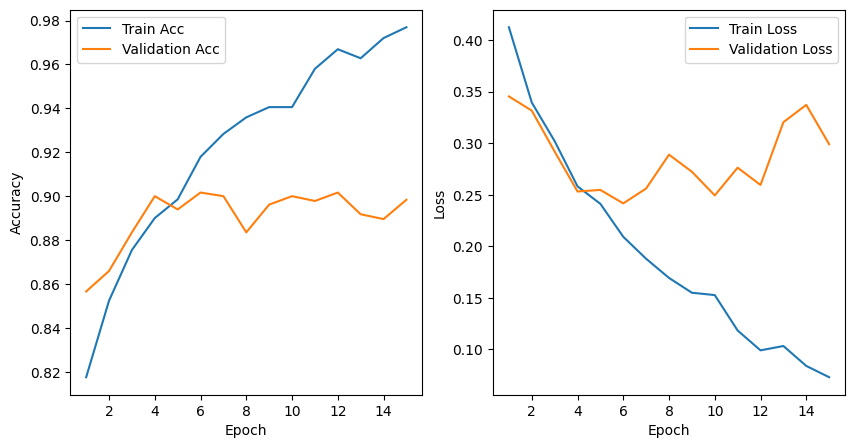

In [ ]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

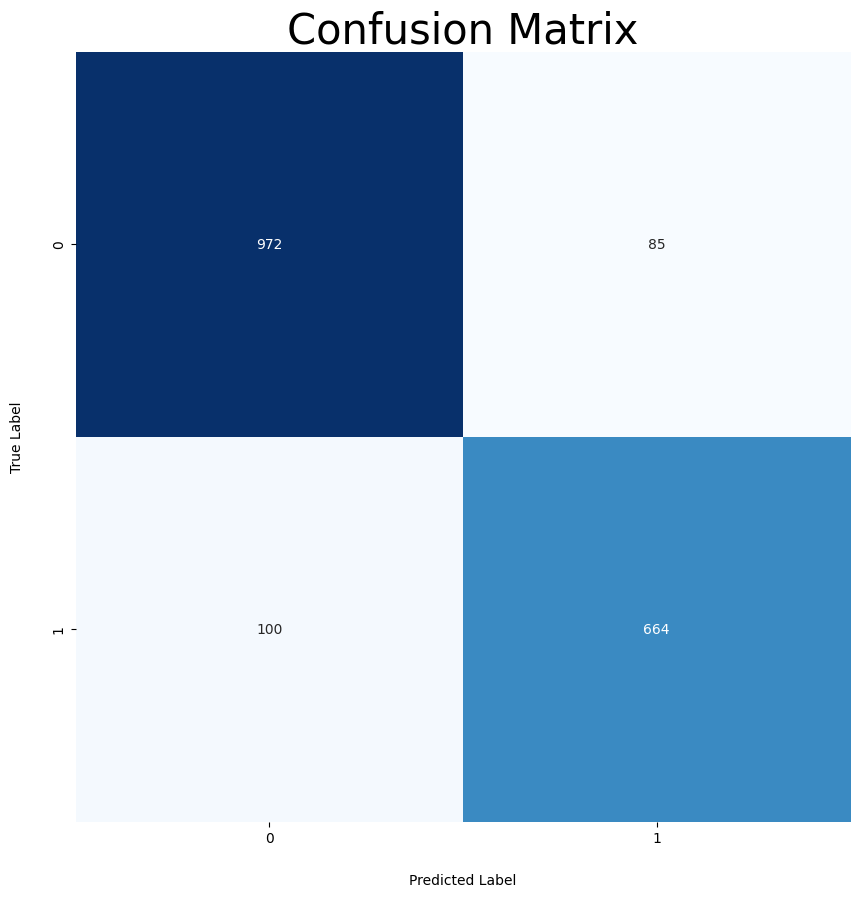

In [ ]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [ ]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.894
F1:        0.895
Precision: 0.897
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1057
           1       0.89      0.87      0.88       764

    accuracy                           0.90      1821
   macro avg       0.90      0.89      0.90      1821
weighted avg       0.90      0.90      0.90      1821



In [ ]:
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")